Credit risk analytics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

In [3]:
loan = pd.read_csv('C:/Alabs/Datasets/bankloans - 1656936041780.csv', sep= ',')
loan

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN


In [4]:
def fn_desc( x ):
    # missing values calculation
    ntot = x.shape[0]
    n = x.count()
    n_miss = ntot - n
    n_miss_perc = n_miss/ntot
    
    # get the lc and uc using IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1
    lc_iqr = q1 - 1.5 * IQR
    uc_iqr = q3 + 1.5 * IQR
    
    # return the descriptives
    
    return pd.Series([x.dtype, x.nunique(),
                       ntot, n, n_miss, n_miss_perc,
                      IQR, lc_iqr, uc_iqr,
                      x.sum(), x.mean(), x.var(), x.std(),
                      x.min(), 
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), 
                      x.max() ],
                     index = ['dtype', 'cardinality',
                               'ntot', 'n', 'n_miss', 'n_miss_perc',
                              'IQR', 'lc_iqr', 'uc_iqr',
                              'sum', 'mean', 'var', 'std',
                              'min', 
                              'p1', 'p5', 'p10', 
                              'p25', 'p50', 'p75', 
                              'p90', 'p95', 'p99',
                              'max' ])

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [6]:
loan.default.value_counts()

default
0.0    517
1.0    183
Name: count, dtype: int64

In [7]:
loan.default.notna().sum()

700

In [8]:
loan.default.value_counts() / loan.default.notna().sum()

default
0.0    0.738571
1.0    0.261429
Name: count, dtype: float64

Since 150 records do not have a label, dividing the dataset into 2 parts 'exist_loan' and 'new_loan'

In [9]:
exist_loan = loan[loan.default.notna()]
exist_loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [10]:
new_loan = loan[loan.default.isna()]
new_loan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


In [11]:
exist_loan.shape

(700, 9)

In [12]:
new_loan.shape

(150, 9)

In [13]:
exist_loan.apply( fn_desc)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
ntot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
n_miss,0,0,0,0,0,0,0,0,0
n_miss_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,11.0,1.0,9.0,9.0,31.0,9.125,1.532896,2.878887,1.0
lc_iqr,12.5,-0.5,-10.5,-10.5,-22.5,-8.6875,-1.930284,-3.274152,-1.5
uc_iqr,56.5,3.5,25.5,25.5,101.5,27.8125,4.201299,8.241395,2.5
sum,24402,1206,5872,5795,31921,7182.4,1087.486972,2140.746028,183.0


In [14]:
exist_loan.columns.difference(['ed'])

Index(['address', 'age', 'creddebt', 'debtinc', 'default', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [15]:
# separating categorical and continuous variables
cat = exist_loan['ed']
cont = exist_loan[exist_loan.columns.difference(['ed'])]

In [16]:
def impute_outlier_iqr(df):
    cols = df.columns
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    iqr = q3 - q1
    lc = q1 - (1.5 * iqr)
    uc = q3 + (1.5 * iqr)

    df = np.clip(df, lc, uc, axis = 1 )
    return df
    

In [17]:
exist_loan = impute_outlier_iqr(cont)

In [18]:
cont.apply(fn_desc)

,address,age,creddebt,debtinc,default,employ,income,othdebt
dtype,int64,int64,float64,float64,float64,int64,int64,float64
cardinality,31,37,695,231,2,32,114,699
ntot,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700
n_miss,0,0,0,0,0,0,0,0
n_miss_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,9.0,11.0,1.532896,9.125,1.0,9.0,31.0,2.878887
lc_iqr,-10.5,12.5,-1.930284,-8.6875,-1.5,-10.5,-22.5,-3.274152
uc_iqr,25.5,56.5,4.201299,27.8125,2.5,25.5,101.5,8.241395
sum,5795,24402,1087.486972,7182.4,183.0,5872,31921,2140.746028


In [19]:
exist_loan_OT = pd.concat([cont, cat], axis = 1 )
exist_loan_OT

,address,age,creddebt,debtinc,default,employ,income,othdebt,ed
0,12,41,11.359392,9.3,1.0,17,176,5.008608,3
1,6,27,1.362202,17.3,0.0,10,31,4.000798,1
2,14,40,0.856075,5.5,0.0,15,55,2.168925,1
3,14,41,2.658720,2.9,0.0,15,120,0.821280,1
4,0,24,1.787436,17.3,1.0,2,28,3.056564,2
...,...,...,...,...,...,...,...,...,...
695,15,36,0.262062,4.6,1.0,6,27,0.979938,2
696,4,29,0.369495,11.5,0.0,6,21,2.045505,2
697,3,33,0.491264,7.6,0.0,15,32,1.940736,1
698,22,45,2.302608,8.4,0.0,19,77,4.165392,1


In [20]:
corr_df = exist_loan_OT.corr()
corr_df

,address,age,creddebt,debtinc,default,employ,income,othdebt,ed
address,1.000000,0.597591,0.208435,0.011323,-0.164451,0.322334,0.316245,0.226514,0.056919
age,0.597591,1.000000,0.295207,0.016398,-0.137657,0.536497,0.478710,0.340217,0.022325
creddebt,0.208435,0.295207,1.000000,0.501767,0.244740,0.403694,0.570199,0.633104,0.088274
debtinc,0.011323,0.016398,0.501767,1.000000,0.389575,-0.031182,-0.026777,0.584870,0.008838
default,-0.164451,-0.137657,0.244740,0.389575,1.000000,-0.282978,-0.070970,0.145713,0.114676
employ,0.322334,0.536497,0.403694,-0.031182,-0.282978,1.000000,0.619681,0.406091,-0.153621
income,0.316245,0.478710,0.570199,-0.026777,-0.070970,0.619681,1.000000,0.610659,0.235190
othdebt,0.226514,0.340217,0.633104,0.584870,0.145713,0.406091,0.610659,1.000000,0.165459
ed,0.056919,0.022325,0.088274,0.008838,0.114676,-0.153621,0.235190,0.165459,1.000000


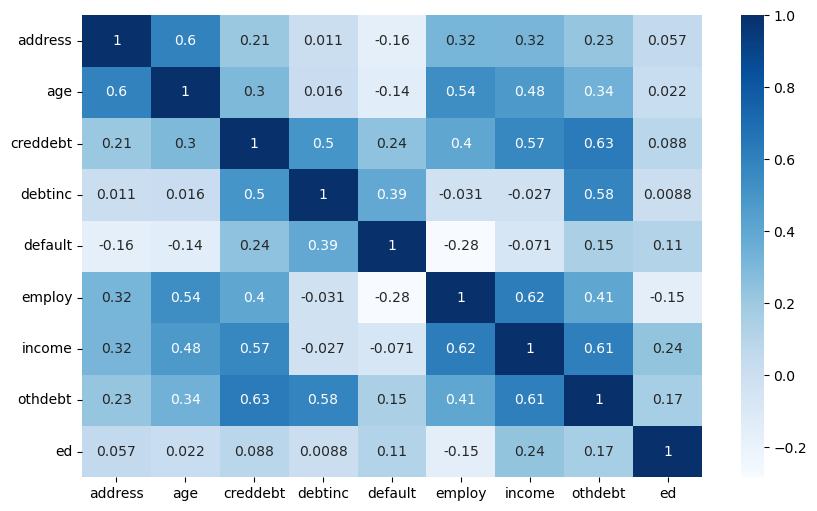

In [21]:

plt.figure(figsize = (10, 6))
sns.heatmap(corr_df, cmap = "Blues", annot = True) 
plt.show()

### Building a logistic regression model

In [22]:
train, test = train_test_split( exist_loan_OT, test_size = 0.3, random_state= 1 )

In [23]:
train.columns.difference(['default'])

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [24]:
m_eq = 'default ~' + '+'.join(train.columns.difference(['default']))
m_eq

'default ~address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [25]:
m0 = smf.logit(m_eq, train).fit()

Optimization terminated successfully.
         Current function value: 0.392887
         Iterations 7


In [26]:
print(m0.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.311     
Date:               2024-07-08 07:05 AIC:              403.0290  
No. Observations:   490              BIC:              440.7787  
Df Model:           8                Log-Likelihood:   -192.51   
Df Residuals:       481              LL-Null:          -279.32   
Converged:          1.0000           LLR p-value:      2.2498e-33
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.9253    0.7437  -2.5887  0.0096  -3.3831  -0.4676
address       -0.1082    0.0276  -3.9150  0.0001  -0.1624  -0.0540
age            0.0435    0.0204   2.1365  0.0326   0.0036   0.0835
creddebt       0.6508    0.138

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
df = pd.DataFrame()

for var in exist_loan_OT.columns.difference(['default']):
    model = smf.logit(formula= 'default ~'+ var, data= exist_loan_OT).fit()
    y_pred = model.predict(exist_loan_OT)
    roc_score = roc_auc_score(y_true= exist_loan_OT.default, y_score= y_pred)
    somarsd = 2 * roc_score - 1
    temp_df = pd.DataFrame([var, roc_score, somarsd]).T
    df = pd.concat([df, temp_df], axis = 0)

df.columns = ['Feature', 'roc_auc_score', 'SomarsD']



Optimization terminated successfully.
         Current function value: 0.559938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.571691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564828
         Iterations 5


In [29]:
df

,Feature,roc_auc_score,SomarsD
0,address,0.611192,0.222384
0,age,0.603202,0.206403
0,creddebt,0.636189,0.272378
0,debtinc,0.7353,0.470601
0,ed,0.573982,0.147964
0,employ,0.704569,0.409138
0,income,0.600168,0.200336
0,othdebt,0.586914,0.173828


In [30]:
features = list (df.loc[df.SomarsD >= 0.2, 'Feature'])
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

In [41]:
# VIF - Variance Inflation Factor
eq = 'default ~'+'+'.join(features)
a,b = dmatrices(eq, data = exist_loan_OT, return_type= 'dataframe')
vif = pd.DataFrame()
vif['features'] = b.columns
vif['vif_factor'] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif

,features,vif_factor
0,Intercept,27.879222
1,address,1.560429
2,age,2.017325
3,creddebt,2.492484
4,debtinc,1.675609
5,employ,1.876615
6,income,2.411474


since all the features have vif values less than 5, we will retain all the above features.

In [44]:
# Build the Final Model

mod_eq = 'default ~'+'+'.join(features)
model_1 = smf.logit(mod_eq, train).fit()
print(model_1.summary2())

Optimization terminated successfully.
         Current function value: 0.393141
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.310     
Date:               2024-07-08 07:24 AIC:              399.2779  
No. Observations:   490              BIC:              428.6387  
Df Model:           6                Log-Likelihood:   -192.64   
Df Residuals:       483              LL-Null:          -279.32   
Converged:          1.0000           LLR p-value:      8.6779e-35
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.9018    0.6298  -3.0198  0.0025  -3.1361  -0.6675
address       -0.1077    0.0277  -3.8939  0.0001  -0.1619  -0.

Income variable seems to be insignificant, hence building the model without income.

In [49]:
fin_features = ['address', 'age', 'creddebt', 'debtinc', 'employ']
mod_eq_f = 'default ~'+'+'.join(fin_features)
model_2 = smf.logit(mod_eq_f, train).fit()
print(model_2.summary2())

Optimization terminated successfully.
         Current function value: 0.394180
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.309     
Date:               2024-07-08 07:44 AIC:              398.2965  
No. Observations:   490              BIC:              423.4629  
Df Model:           5                Log-Likelihood:   -193.15   
Df Residuals:       484              LL-Null:          -279.32   
Converged:          1.0000           LLR p-value:      2.2999e-35
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -2.0533    0.6116  -3.3573  0.0008  -3.2520  -0.8546
address       -0.1085    0.0275  -3.9441  0.0001  -0.1624  -0.

In [50]:
### predict the labels for test and train data
train_pred = model_2.predict(train)
test_pred = model_2.predict(test)
print(train_pred)
print(test_pred)

286    0.037474
146    0.473845
214    0.152331
528    0.002557
165    0.616963
         ...   
144    0.004511
645    0.429528
72     0.006585
235    0.131636
37     0.343037
Length: 490, dtype: float64
681    0.232333
626    0.103875
329    0.131377
620    0.346897
399    0.385114
         ...   
160    0.367648
442    0.064253
611    0.064412
578    0.324634
103    0.003568
Length: 210, dtype: float64


In [51]:
# Model scoring
train_data = pd.concat([train.default, train_pred], axis = 1)
test_data = pd.concat([test.default, test_pred], axis = 1)


In [56]:
train_data.columns = ['y_act', 'y_pred_proba']
test_data.columns = ['y_act', 'y_pred_proba']

In [59]:
train_data.head()

,y_act,y_pred_proba
286,0.0,0.037474
146,0.0,0.473845
214,0.0,0.152331
528,0.0,0.002557
165,1.0,0.616963


In [60]:
test_data.head()

,y_act,y_pred_proba
681,1.0,0.232333
626,0.0,0.103875
329,0.0,0.131377
620,0.0,0.346897
399,1.0,0.385114


In [62]:
concordance_train = roc_auc_score(train_data.y_act, train_data.y_pred_proba)
concordance_test = roc_auc_score(test_data.y_act, test_data.y_pred_proba)
print( 'Train:', concordance_train, 'Test:', concordance_test )

Train: 0.8562925170068028 Test: 0.8602224515537208


Model accuracy at 0.5 cutoff

In [63]:
train_data['y_pred'] = np.where(train_data.y_pred_proba >= 0.5, 1, 0)

In [65]:
train_data

,y_act,y_pred_proba,y_pred
286,0.0,0.037474,0
146,0.0,0.473845,0
214,0.0,0.152331,0
528,0.0,0.002557,0
165,1.0,0.616963,1
...,...,...,...
144,0.0,0.004511,0
645,1.0,0.429528,0
72,0.0,0.006585,0
235,0.0,0.131636,0


In [70]:
# confusion matrix
pd.crosstab(train_data.y_act, train_data.y_pred).loc[::-1, ::-1]

y_pred,1,0
y_act,,
1.0,62,64
0.0,28,336


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

In [75]:
cm_p50 = confusion_matrix(train_data.y_act, train_data.y_pred)[::-1, ::-1]
cm_p50

array([[ 62,  64],
       [ 28, 336]], dtype=int64)

In [99]:
tp = cm_p50[0,0]
tn = cm_p50[1,1]
fp = cm_p50[1,0]
fn = cm_p50[0,1]
accuracy = (tp + tn)/cm_p50.sum()
tpr = tp / (tp + fn) # out of total positives, what percentage are predicted positive?
fpr = fp / (fp + tn)
precision_ = tp / (tp + fp) # out of all the positives predicted, how many were actually positive?

print(cm_p50)
print('accuracy: ', accuracy, '| tpr: ', tpr, '| fpr: ', fpr, 'precision:', precision_ , 'Recall:' , tpr  )

[[ 62  64]
 [ 28 336]]
accuracy:  0.8122448979591836 | tpr:  0.49206349206349204 | fpr:  0.07692307692307693 precision: 0.6888888888888889 Recall: 0.49206349206349204


In [98]:
print(classification_report(train_data.y_act, train_data.y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       364
         1.0       0.69      0.49      0.57       126

    accuracy                           0.81       490
   macro avg       0.76      0.71      0.73       490
weighted avg       0.80      0.81      0.80       490



#### get the best cutoff  

# empty dataframe to store the information
cm_scores = pd.DataFrame()

# run the loop for different proba values
for prob_val in np.arange( 0, 1.01, 0.01 ):
    
    # get the y_pred
    train_data['y_pred'] = np.where( train_data.y_pred_proba >= prob_val, 1, 0 )
    
    # get the confusion matrix
    cm = confusion_matrix( train_data.y_actual, train_data.y_pred )[::-1, ::-1]

    # get the metric values
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]

    accuracy = (tp + tn) / cm.sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    s_s = tpr + 1 - fpr
    
    # store the data in temp dataframe
    temp_df = pd.DataFrame([prob_val, tp, tn, fp, fn, accuracy, tpr, fpr, s_s]).T

In [106]:
# empty dataframe to store the information
cm_scores = pd.DataFrame()

# running the loop for different proba values
for prob_val in np.arange(0, 1.01, 0.01) :
    
    # get the y_pred
    train_data['y_pred'] = np.where( train_data.y_pred_proba >= prob_val, 1, 0 )
    
    # get the confusion matrix
    cm = confusion_matrix( train_data.y_act, train_data.y_pred )[::-1, ::-1]

    # get the metric values
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]

    accuracy = (tp + tn) / cm.sum()
    tpr  = tp / (tp + fn)
    fpr = fp / (fp + tn)
    s_s = tpr + 1 - fpr

    # store the data in temp dataframe
    temp_df = pd.DataFrame([prob_val, tp, tn, fp, fn, accuracy, tpr, fpr, s_s]).T

    # add the data to final dataframe
    cm_scores = pd.concat([cm_scores, temp_df], axis = 0 )

        
# add the column names
cm_scores.columns = ['prob_val', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'tpr', 'fpr', 's_s']


# get the best cutoff
best_cutoff = cm_scores.loc[ cm_scores.s_s == cm_scores.s_s.max(), 'prob_val'][0]
print('best_cutoff: ', best_cutoff)

best_cutoff:  0.32
